![](./figures/Logo.PNG)

## In this part of the tutorial, you will
* use regional sensitivity analysis (RSA)
* use Generalized Likelihood Uncertainty Estimation (GLUE)
* program history matching

---

# 4 a - Regional sensitivity analysis (RSA)

---

## 1 Introduction

Regional sensitivity analysis evaluates how variations in input parameters impact the outcomes of a model. 

Today, we use statistical metrics to distinguish between parameter sets that produce behavioral and non-behavorial simulation output.
We apply the same metrics to implement and assess Generalized Likelihood Uncertainty Estimation (GLUE). In the last exercise, you will write a code to produce a History Matching.

## 2 Separating into behavioral and non-behavioral model runs

**Set current working directory and import python modules**

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import sys
import seaborn as sns
import matplotlib.dates as mdate
sys.path.append('src/')
import RSA_thres as Rt # module to perform RSA with threshold
import plot_functions as pf # module to visualize the results
from sampling import AAT_sampling # module to perform the input sampling

import HyMod

# Supress warnings from numba package
import logging;
logger = logging.getLogger("numba");
logger.setLevel(logging.ERROR)

from ipywidgets import interact, Dropdown

**Define functions**

In [2]:
def rmse(obs, sim):
    return np.sqrt(np.mean((obs - sim)**2))

def abs_bias(obs, sim):
    return abs(np.mean(np.subtract(obs, sim)))
    
def hymod_func(param, rain, evap, runoff_obs, obj_fun1, obj_fun2):
    # run HyMod
    param = np.array([param[0], param[1], param[2], 1/param[3], 1/param[4]])
    runoff_sim, states, fluxes = HyMod.hymod_sim(param, rain, evap)
    errors = np.nan * np.ones((2,))
    errors[0] = obj_fun1(runoff_obs[n_days:], runoff_sim[n_days:])
    errors[1] = obj_fun2(runoff_obs[n_days:], runoff_sim[n_days:])
    return errors, runoff_sim[n_days:]

**Load data, prepare input data**

In [3]:
# DO NOT ALTER code to select the catchment

catchment_names = ["Pere Marquette River, MI, USA", "Trout River, BC, Canada", 
                   "Siletz River, OR, USA", "Medina River, TX, USA",
                   "South Branch Potomac River, USA", "Bad River, Wisconsin, USA"]

dropdown_catchment = Dropdown(
    options=catchment_names,
    description="Catchment:",
    index=1
)

display(dropdown_catchment)

Dropdown(description='Catchment:', index=1, options=('Pere Marquette River, MI, USA', 'Trout River, BC, Canada…

In [4]:
# Read catchment data
catchment_name = dropdown_catchment.value
file_dic = {catchment_names[0]: "camels_04122500", catchment_names[1]: "hysets_10BE007", 
            catchment_names[2]: "camels_14305500", catchment_names[3]: "camels_08178880",
            catchment_names[4]: "camels_01605500", catchment_names[5]: "camels_04027000"}
df_obs = pd.read_csv(f"data/{file_dic[catchment_name]}.csv")
# Make sure the date is interpreted as a datetime object -> makes temporal operations easier
df_obs.date = pd.to_datetime(df_obs['date'], format='%Y-%m-%d')
# Index frame by date
df_obs.set_index('date', inplace=True)
# Select time frame
start_date = '2002-01-01'
end_date = '2003-12-31'
df_obs = df_obs[start_date:end_date]
n_days = 365  # days for the model to spin-up (fill with water)
# Reformat the date for plotting
df_obs["date"] = df_obs.index.map(lambda s: s.strftime('%b-%d-%y'))
# Reindex
df_obs = df_obs.reset_index(drop=True)
# Select snow, precip, PET, streamflow and T
df_obs = df_obs[["snow_depth_water_equivalent_mean", "total_precipitation_sum","potential_evaporation_sum","streamflow", "temperature_2m_mean", "date"]]
# Rename variables
df_obs.columns = ["Snow [mm/day]", "P [mm/day]", "PET [mm/day]", "Q [mm/day]", "T [C]", "Date"]

# Extract time series
P = df_obs["P [mm/day]"].to_numpy()
pet = df_obs["PET [mm/day]"].to_numpy()
#temp = df_obs["T [C]"].to_numpy()
Q_obs = df_obs["Q [mm/day]"].to_numpy()

# Number of uncertain parameters subject to SA:
M = 5

# Parameter ranges:
xmin = [1, 0, 0, 8, 1]
xmax = [400, 2, 1, 200, 7]

# Parameter distributions:
distr_fun = st.uniform # uniform distribution
# The shape parameters of the uniform distribution are the lower limit and the
# difference between lower and upper limits:
distr_par = [np.nan] * M
for i in range(M):
    distr_par[i] = [xmin[i], xmax[i] - xmin[i]]

# Name of parameters (will be used to customize plots):
parameter_names = ['Sm', 'beta', 'alfa', 'Rs', 'Rf']

samp_strat = "lhs"  # Latin Hypercube sampling

**Scatter plots of parameters indicating behavioral/non-behavioral model runs**

In [5]:
@interact(N = (60,1000,20), rmse_threshold = (0.1,20,0.1), bias_threshold = (0,10,0.1))
def behavioral_or_not(N = 200, rmse_threshold = 0.7, bias_threshold = 0.6):
    try:
        dic_threshold = {'rmse': rmse_threshold, 'bias': bias_threshold} 
        parameter_set = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)
        # loop through model runs
        errors = np.nan * np.ones((parameter_set.shape[0], len(dic_threshold)))
        for j in range(N):
            errors[j,:], _ = hymod_func(parameter_set[j,:], P, pet, Q_obs, rmse, abs_bias)
        # RSA (find behavioural parameterizations, i.e. parameterizations with output values below the threshold):
        mvd, spread, irr, idxb = Rt.RSA_indices_thres(parameter_set, errors, [rmse_threshold, bias_threshold])
    
        if idxb.sum() == 0:
            raise Exception("No parameter combination resulted in behavioral model results (determined using objective function thresholds).")  

        # plot results
        print(f"Behavorial parameter sets (shown in red): {idxb.sum()}")
        print(f"Non-Behavorial parameter sets (shown in blue): {idxb.size - idxb.sum()}")
        i = 0
        for str_metric in dic_threshold.keys():
                plt.figure(figsize=(13,3.5))
                pf.scatter_plots(parameter_set, errors[:, i], Y_Label=str_metric, X_Labels=parameter_names, idx=idxb)
                plt.show()
                i += 1
    except Exception as error:
        print("An error occurred:", error)

interactive(children=(IntSlider(value=200, description='N', max=1000, min=60, step=20), FloatSlider(value=0.7,…

<div style="background:#e0f2fe;border:1mm solid SkyBlue; padding:1%">
    <h4><span>&#129300 </span>Your Turn I: Thresholds</h4>
    <ol>
        <li>How does changing the thresholds affect the result of the analysis? </li>
        <li>How suitable are the parameter ranges?</li>
        <li>How do the two objective functions interact in defining behavioral parameter sets?</li>
    </ol>
</div>

**Plot parameter CDFs with legend**

In [6]:
@interact(N = (60,1000,20), rmse_threshold = (0.1,20,0.01), bias_threshold = (0,10,0.1))
def behavioral_or_not_2(N = 200, rmse_threshold = 0.7, bias_threshold = 0.6):  
    try:
        dic_threshold = {'rmse': rmse_threshold, 'bias': bias_threshold} 
        parameter_set = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)
        # loop through model runs
        errors = np.nan * np.ones((parameter_set.shape[0], len(dic_threshold)))
        for j in range(N):
            errors[j,:], _ = hymod_func(parameter_set[j,:], P, pet, Q_obs, rmse, abs_bias)
        # RSA (find behavioural parameterizations, i.e. parameterizations with output values below the threshold):
        mvd, spread, irr, idxb = Rt.RSA_indices_thres(parameter_set, errors, [rmse_threshold, bias_threshold])
        if idxb.sum() == 0:
            raise Exception("No parameter combination resulted in behavioral model results (determined using objective function thresholds).")  
        print(f"Behavorial parameter sets: {idxb.sum()}")
        print(f"Non-Behavorial parameter sets: {idxb.size - idxb.sum()}")
        plt.figure(figsize=(12,4))
        Rt.RSA_plot_thres(parameter_set, idxb, X_Labels=parameter_names, str_legend=['behav', 'non-behav'])
        plt.show()
    except Exception as error:
        print("An error occurred:", error)

interactive(children=(IntSlider(value=200, description='N', max=1000, min=60, step=20), FloatSlider(value=0.7,…

<div style="background:#e0f2fe;border:1mm solid SkyBlue; padding:1%">
    <h4><span>&#129300 </span>Your Turn II: Thresholds and CDF</h4>
    <ol>
        <li>Using sensible thresholds defined in excercise 1: what do the CDFs tell you about parameter importance?</li>
        <li>How does parameter importance change with objective function and thresholds?</li>
    </ol>
</div>

## 3 Generalized Likelihood Uncertainty Estimation (GLUE)

Running the model 1000 times, computing RMSE and absolute bias
-> finding behavioral parameter sets
Calculating likelihoods for behavioral parameter sets
Computing the 5th and 95th percentile of the 365 evaluated days
Plotting 90% confidence intervals


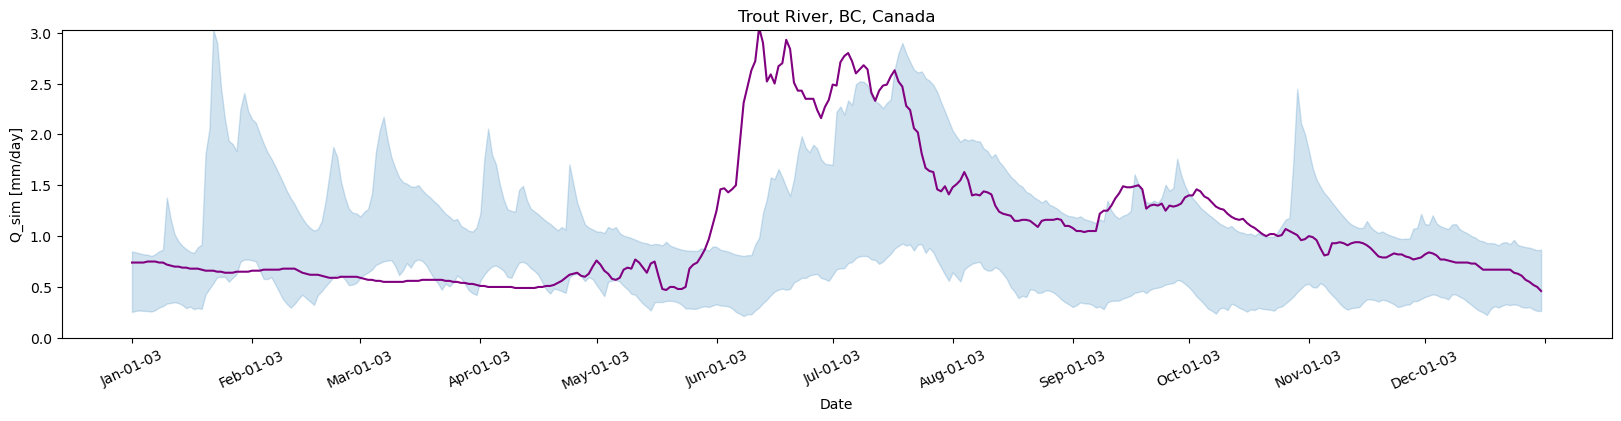

In [7]:
try:
    N_samples = 1000
    print(f"Running the model {N_samples} times, computing RMSE and absolute bias")
    parameter_sets = AAT_sampling("rsu", M, distr_fun, distr_par, N_samples)  # "rsu": code for random uniform sampling
    dic_threshold = {'rmse': 2.2, 'bias': 0.6}  # you can use the thresholds you used above!
    errors = np.nan * np.ones((parameter_sets.shape[0], len(dic_threshold)))
    l_Q_sims_eval = []
    for i, parameter_set in enumerate(parameter_sets):
        errors[i,:], Q_sim_eval = hymod_func(parameter_set, P, pet, Q_obs, rmse, abs_bias)
        l_Q_sims_eval.append(Q_sim_eval)
    Q_sims_eval = np.array(l_Q_sims_eval)
    
    print("-> finding behavioral parameter sets")
    # RSA (find behavioural parameterizations, i.e. parameterizations with output values below the threshold):
    mvd, spread, irr, idxb = Rt.RSA_indices_thres(parameter_sets, errors, [dic_threshold["rmse"], dic_threshold["bias"]])
    if idxb.sum() == 0:
        raise Exception("No parameter combination resulted in behavioral model results (determined using objective function thresholds).")  
        
    print("Calculating likelihoods for behavioral parameter sets") 
    Q_obs_eval = Q_obs[n_days:]
    l_df_glue = []
    exponent = 1
    for parameter_set_id, behavioral in enumerate(idxb):  # idxb is an array containing True/False when parameter set is behavorial/non-behavorial
        if behavioral:
            Q_sim_behav = Q_sims_eval[parameter_set_id,:]
            likelihood = pow( np.var(Q_obs_eval-Q_sim_behav), -exponent)
            l_df_glue.append(pd.DataFrame({"likelihood":likelihood, "Q_sim [mm/day]": Q_sim_behav}))
    df_glue = pd.concat(l_df_glue)
    df_glue = df_glue.reset_index(names="timestep")

    number_of_evaluated_days = len(Q_obs_eval)
    print(f"Computing the 5th and 95th percentile of the {number_of_evaluated_days} evaluated days")
    l_Q_sims_5 = []
    l_Q_sims_95 = []
    for timestep in range(0, number_of_evaluated_days):
        df_glue_at_t = df_glue[df_glue["timestep"] == timestep]  # get simulated runoff of all parameter sets at current timestep
        df_glue_at_t = df_glue_at_t.sort_values(by="Q_sim [mm/day]", ignore_index=True)  # sort the simulated runoff at timestep by value
        df_glue_at_t["likelihood cumsum"] = df_glue_at_t["likelihood"].cumsum() / df_glue_at_t["likelihood"].sum()
        #likelihood_cumsum = np.cumsum(df_glue_at_t["likelihood"].to_numpy()) / np.sum(df_glue_at_t["likelihood"].to_numpy())
        id_5 = np.abs(df_glue_at_t["likelihood cumsum"].to_numpy() - 0.05).argmin()  # find id where cumulative sum of likelihood sorted by Q_sim_behav is closest to 0.05 
        id_95 = np.abs(df_glue_at_t["likelihood cumsum"].to_numpy() - 0.95).argmin() # find id where cumulative sum of likelihood sorted by Q_sim_behav is closest to 0.95 
        #print(f"likelihood_cumsum[id_5]: {likelihood_cumsum[id_5]}")
        
        Q_sim_sorted = df_glue_at_t["Q_sim [mm/day]"].to_numpy()
        l_Q_sims_5.append(Q_sim_sorted[id_5])  # append results to lists
        l_Q_sims_95.append(Q_sim_sorted[id_95])  # append results to lists

        #if timestep == 0:
        #    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
        #    sns.scatterplot(df_glue_at_t, x="Q_sim [mm/day]", y="likelihood")
        #    plt.show()
    
    # Transform data to dataframes
    df_Q_sims_5 = pd.DataFrame({"Q_sim [mm/day]": np.array(l_Q_sims_5), "Date": df_obs["Date"].to_numpy()[n_days:]})
    df_Q_sims_95 = pd.DataFrame({"Q_sim [mm/day]": np.array(l_Q_sims_95), "Date": df_obs["Date"].to_numpy()[n_days:]})
    df_Q_sims = pd.concat([df_Q_sims_5, df_Q_sims_95])
    
    print("Plotting 90% confidence intervals")
    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    sns.lineplot(df_Q_sims, x="Date", y="Q_sim [mm/day]", linewidth=0)  # plot only the confidence bound
    #sns.lineplot(df_Q_sims_5, x="Date", y="Q_sim [mm/day]", color="blue")  # plot the 5th percentile
    #sns.lineplot(df_Q_sims_95, x="Date", y="Q_sim [mm/day]", color="green")  # plot the 95th percentile
    sns.lineplot(df_obs[n_days:], x="Date", y="Q [mm/day]", color="purple")
    
    # Show only the main ticks
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    ax.set_title(catchment_name)
    plt.xticks(rotation=25)
    #plt.yscale("log")
    plt.ylim(bottom=0, top=df_Q_sims["Q_sim [mm/day]"].max())
    plt.show()
    
except Exception as error:
    print("An error occurred:", error)

---

<div style="background:#e0f2fe;border:1mm solid SkyBlue; padding:1%">
    <h4><span>&#129300 </span>Your Turn III: GLUE</h4>
    <ol>
        <li>How well does the GLUE ensemble predict the observations?</li>
        <li>How would you quantify this performance?</li>
        <li>Implement history matching in the python code cell below!</li>
    </ol>
</div>

## 4 History matching

In [8]:
# code here